In [1]:
import numpy as np

In [2]:
from tqdm import tqdm_notebook as tqdm

In [38]:
import matplotlib.gridspec as gridspec

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

### Extraction des données

##### Binary Alpha Digits

Import du fichier .mat

référence : https://docs.scipy.org/doc/scipy/reference/tutorial/io.html

In [3]:
import scipy.io as sio

In [89]:
classlabels = sio.loadmat('binaryalphadigs.mat')['classlabels'][0]
np.save('BAD_classlabels.npy',classlabels)

In [8]:
dat = sio.loadmat('binaryalphadigs.mat')['dat']
np.save('BinaryAlphaDigs.npy',dat)

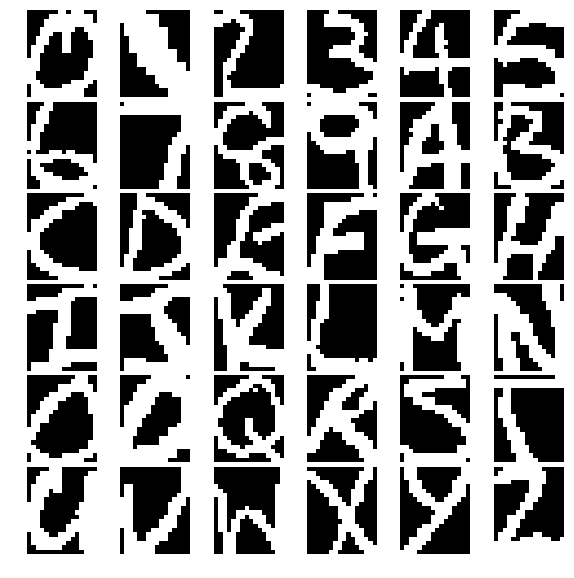

In [49]:
plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(len(dat)):
    
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.imshow(dat[i,np.random.randint(0,len(dat[i])-1)],cmap=plt.cm.gray)
    
plt.show()

##### MNIST

from : https://stackoverflow.com/a/53181925

In [45]:
import struct

In [70]:
def read_images(filename,filesave):
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
    np.save(filesave,data)

In [73]:
def read_labels(filename,filesave):
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f,dtype=np.dtype(np.uint8))
    np.save(filesave,labels)

In [72]:
read_images('../MNIST/t10k-images-idx3-ubyte','MNIST_test_images.npy')
read_images('../MNIST/train-images-idx3-ubyte','MNIST_train_images.npy')

In [75]:
read_labels('../MNIST/t10k-labels-idx1-ubyte','MNIST_test_labels.npy')
read_labels('../MNIST/train-labels-idx1-ubyte','MNIST_train_labels.npy')

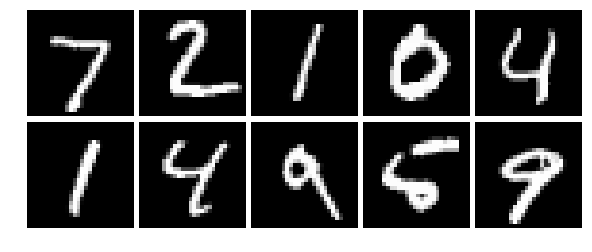

In [58]:
plt.figure(figsize = (10,4))
gs1 = gridspec.GridSpec(2, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(10):
    
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.imshow(data[i,:,:],cmap=plt.cm.gray)
    
plt.show()

### Reading npy files

In [90]:
AD = np.load('BinaryAlphaDigs.npy')
AD_labels = np.load('BAD_classlabels.npy')

In [78]:
MNIST_test_images = np.load("MNIST_test_images.npy")
MNIST_test_labels = np.load("MNIST_test_labels.npy")
MNIST_train_images = np.load("MNIST_train_images.npy")
MNIST_train_labels = np.load("MNIST_train_labels.npy")

# 3.1 Construction d'un RBM et test sur Binary AlphaDigits

In [151]:
def lire_alpha_digit(char_list):
    
    AD = np.load('BinaryAlphaDigs.npy')
    AD_labels = np.load('BAD_classlabels.npy')
    
    array_list = []
    
    for c in np.core.defchararray.upper(char_list):
        
        idx = np.where(AD_labels==c)[0][0]
        AD_char = np.array([*AD[0,:]])
        
        n = AD_char.shape[0]
        m = AD_char.shape[1]*AD_char.shape[2]
        
        AD_r = AD_char.reshape([n,m])
        
        array_list.append(AD_r)
        
    return np.concatenate(array_list)

In [139]:
lad = lire_alpha_digit(['A','1'])